In [1]:
import os
import base64
import fitz  
from PIL import Image
import numpy as np
import faiss
from langchain_community.llms import Ollama
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from IPython.display import HTML, display


In [2]:
llm = Ollama(model="llava")


In [3]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Bot

In [4]:
class FAISSIndex:
    def __init__(self, embedding_dim):
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.embeddings = []
        self.documents = []
        self.summaries = []  

    def add_texts(self, texts, embeddings, summaries):
        self.documents.extend(texts)
        self.embeddings.extend(embeddings)
        self.summaries.extend(summaries)
        self.index.add(np.array(embeddings).astype(np.float32))

    def similarity_search(self, query, k=5):
        query_embedding = embedding_model.embed_query(query)
        query_embedding = np.array(query_embedding).astype(np.float32)
        distances, indices = self.index.search(query_embedding.reshape(1, -1), k)
    
        print(f"Indices: {indices}")
        print(f"Documents: {self.documents}")
        print(f"Summaries: {self.summaries}")
    
        results = []
        for idx in indices[0]:
            if 0 <= idx < len(self.documents):
                results.append({"content": self.documents[idx], "summary": self.summaries[idx]})
            else:
                print(f"Index {idx} is out of range.")
    
        return results



In [5]:
text_index = FAISSIndex(embedding_dim=384)
image_index = FAISSIndex(embedding_dim=384)
table_index = FAISSIndex(embedding_dim=384)

In [6]:

def split_text(text, chunk_size=1000, overlap=200):
    text_splitter = CharacterTextSplitter(separator=" ", chunk_size=chunk_size, chunk_overlap=overlap)
    return text_splitter.split_text(text)


In [7]:
def extract_pdf_elements(file_path, output_dir):
    text_content = ""
    table_content = []  
    image_paths = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    pdf_document = fitz.open(file_path)

    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)

        # Extract text from the page
        page_text = page.get_text()
        if page_text:
            text_content += page_text
          
        else:
            print(f"No text found on page {page_num + 1}.")

        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]  
            base_image = pdf_document.extract_image(xref)
            image_data = base_image["image"]
            image_filename = os.path.join(output_dir, f"image_{page_num}_{img_index}.png")
            with open(image_filename, "wb") as image_file:
                image_file.write(image_data)
            image_paths.append(image_filename)
            

    return text_content, table_content, image_paths

In [8]:
def get_summary_text(llm_result):
    try:
        generations_list = llm_result.generations
        if generations_list and isinstance(generations_list[0], list):
            generation_chunk = generations_list[0][0]
            if hasattr(generation_chunk, 'text'):
                return generation_chunk.text.strip()
        return "Text not found."
    except Exception as e:
        return f"An error occurred: {e}"


In [9]:
def generate_summary(content, content_type):
    if content_type == "image":
        encoded_image = base64.b64encode(content).decode('utf-8')
        prompt = "you have great knowledge of plants , trees , leaves and their diseases. Give more appropriate answer according to my context if you not known then return simply no otherwise you give more detailed answer .Describe the following image content."
        response = llm.generate(prompts=[prompt], images=[encoded_image])
    elif content_type == "table":
        prompt = f"you have great knowledge of plants , trees , leaves and their diseases. Give more appropriate answer according to my context if you not known then return simply no otherwise you give more detailed answer .Summarize the following table content: {content}"
        response = llm.generate(prompts=[prompt])
    elif content_type == "text":
        prompt = f"you have great knowledge of plants , trees , leaves and their diseases. Give more appropriate answer according to my context if you not known then return simply no otherwise you give more detailed answer .Summarize the following text: {content}"
        response = llm.generate(prompts=[prompt])
    else:
        return "No summary available."

    summary_text = get_summary_text(response)
    return summary_text


In [10]:
def process_pdf(file_path):
    file_title = os.path.splitext(os.path.basename(file_path))[0]
    output_dir = os.path.join("extracted_images", file_title)
    
    text_content, table_content, image_paths = extract_pdf_elements(file_path, output_dir)
    
    text_chunks = split_text(text_content)
    text_summaries = [generate_summary(chunk, "text") for chunk in text_chunks]
    
    table_summaries = [generate_summary(table, "table") for table in table_content]
    
    image_summaries = []
    for image_path in image_paths:
        with open(image_path, 'rb') as image_file:
            image_data = image_file.read()
        image_summary = generate_summary(image_data, "image")
        image_summaries.append(image_summary)
    
    for i, chunk in enumerate(text_chunks):
        chunk_embedding = embedding_model.embed_query(chunk)
        text_index.add_texts([chunk], [chunk_embedding], [text_summaries[i]])
    
    for i, table in enumerate(table_content):
        table_embedding = embedding_model.embed_query(table)
        table_index.add_texts([table], [table_embedding], [table_summaries[i]])
    
    for i, summary in enumerate(image_summaries):
        image_embedding = embedding_model.embed_query(summary)
        image_index.add_texts([image_paths[i]], [image_embedding], [summary])
    
    return output_dir


In [11]:
def query_system(query):
    text_results = text_index.similarity_search(query)
    table_results = table_index.similarity_search(query)
    image_results = image_index.similarity_search(query)
    
    actual_content = "you have great knowledge of plants , trees , leaves and their diseases. Give more appropriate answer according to my context if you not known then return simply no otherwise you give more detailed answer .summarize all images , texts , tabele in detail not separately the image show or text show only give summary in detail"
    relevant_images = []
    
    for result in text_results:
        content = result['content']
        summary = result['summary']
        actual_content += f"Text: {summary}\n"
    
    for result in table_results:
        content = result['content']
        summary = result['summary']
        actual_content += f"Table: {content}\n"
    
    for result in image_results:
        content = result['content']
        summary = result['summary']
        image_path = content
        if image_path not in relevant_images:
            relevant_images.append(image_path)
        actual_content += f"Image Description: {summary}\n"
    
    
    enhanced_response = llm.generate(prompts=[actual_content])
    
    enhanced_text = get_summary_text(enhanced_response)
    return enhanced_text, relevant_images


In [12]:
def display_single_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            image_data = image_file.read()
        encoded_image = base64.b64encode(image_data).decode('utf-8')
        img_tag = f'<img src="data:image/png;base64,{encoded_image}" alt="Relevant Image" style="max-width: 300px;"/>'
        display(HTML(img_tag))
    except FileNotFoundError:
        print(f"File not found: {image_path}")


Indices: [[ 0  1 -1 -1 -1]]
Documents: ['4\nBP-164-W Symptoms and Signs for Plant Problem Diagnosis – An Illustrated Glossary \nANTHRACNOSE\nIvy anthracnose. This spreading leaf spot is producing erumpent \npustules that produce thousands of spores to spread the disease.\nA group of fungal diseases that often start as leaf spots or fruit \nrots but may also move into petioles, twigs and branches, \nultimately causing cankers or blighting. They are characterized \nby having asexual spores produced in an acervulus.\nCauses: \x07\nFungi, including Apiognomonia spp., Colletotrichum spp., \nGnomonia spp., Kabatiella spp., and Stegophora spp. \nSycamore anthracnose. Pathogen has spread from leaves into branch. \nNote small canker. \nHosta anthracnose invading from unpigmented leaf margin.\nBeech anthracnose. Note small circular leaf spots and spreading \ndiamond-shaped lesions on the midvein.\n6\nBP-164-W Symptoms and Signs for Plant Problem Diagnosis – An Illustrated Glossary \nBLOTCH\nLarg


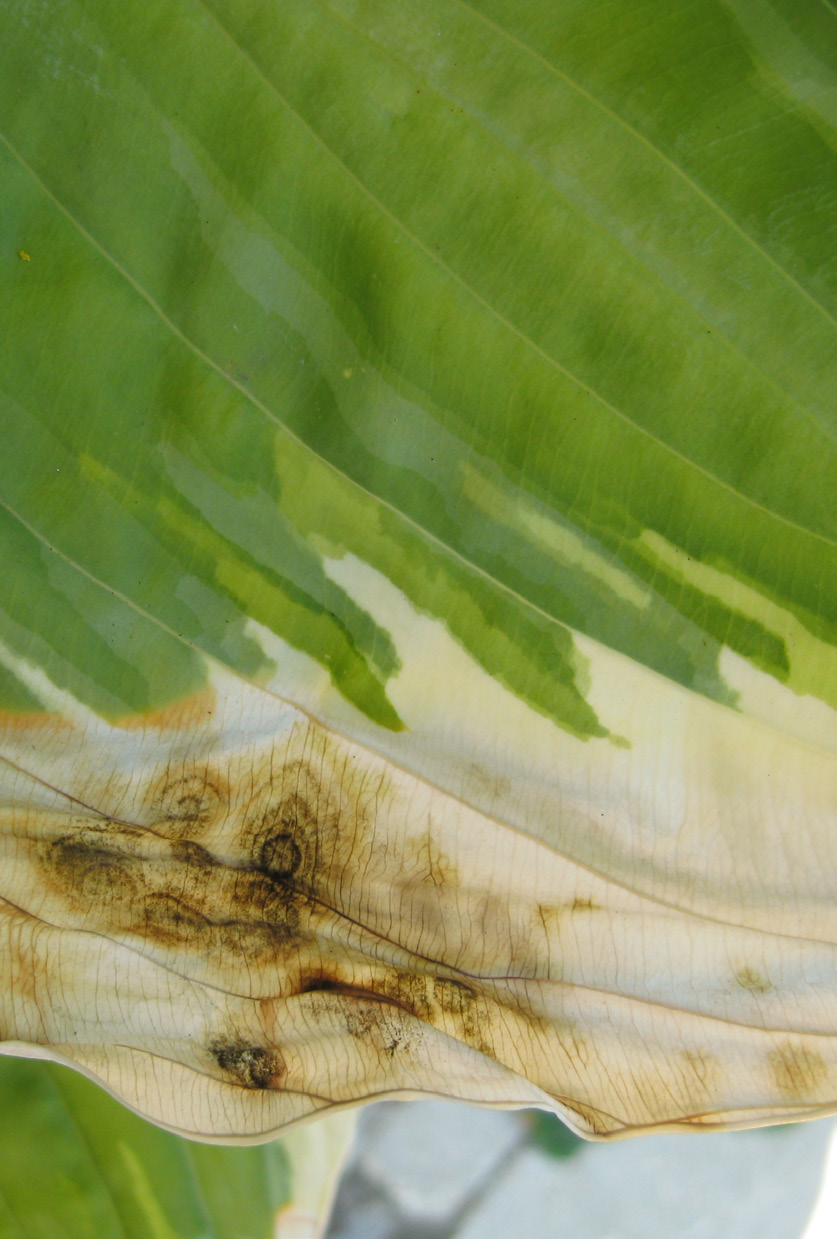

extracted_images\doc2\image_1_0.png



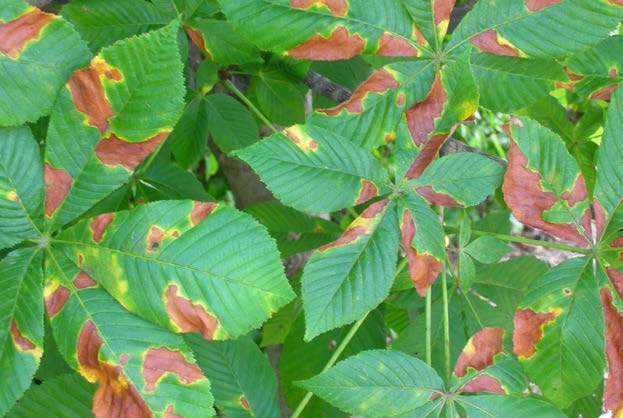

extracted_images\doc2\image_0_2.png



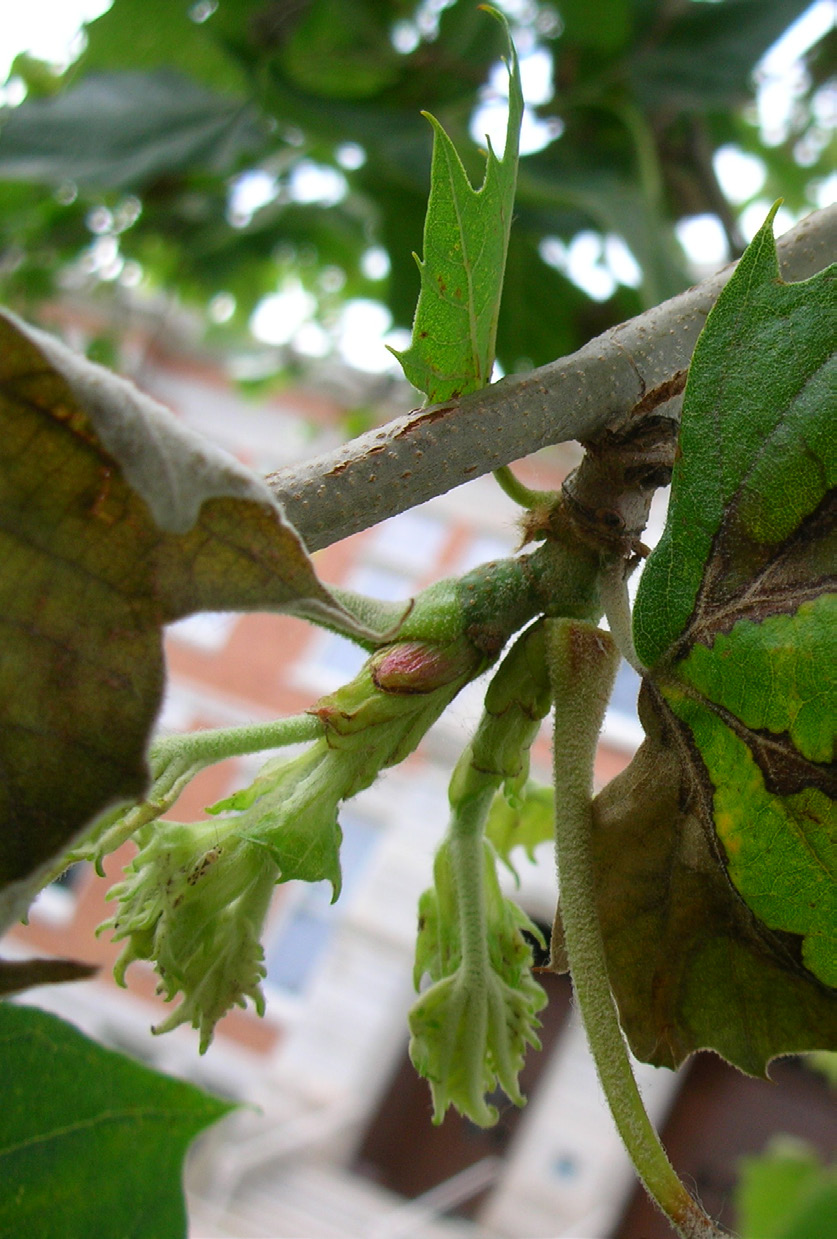

extracted_images\doc2\image_0_3.png



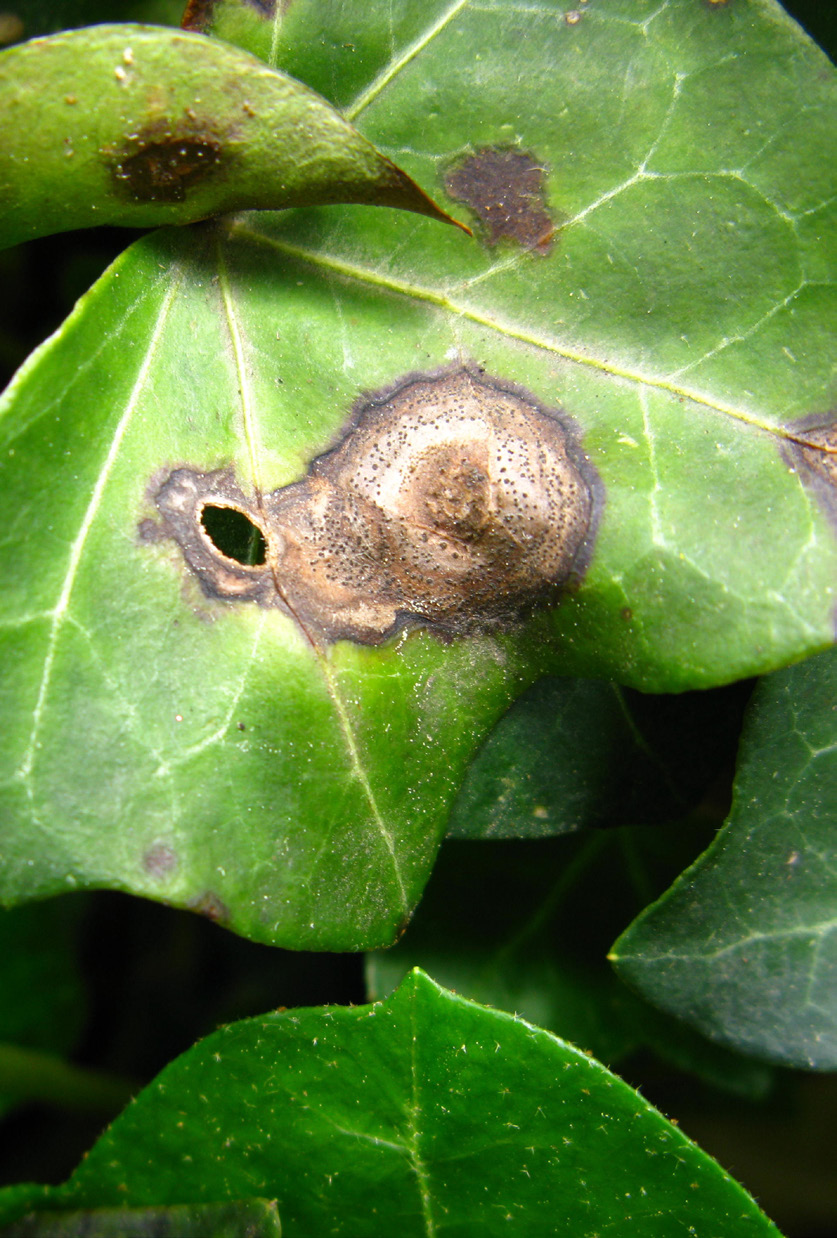

extracted_images\doc2\image_0_1.png



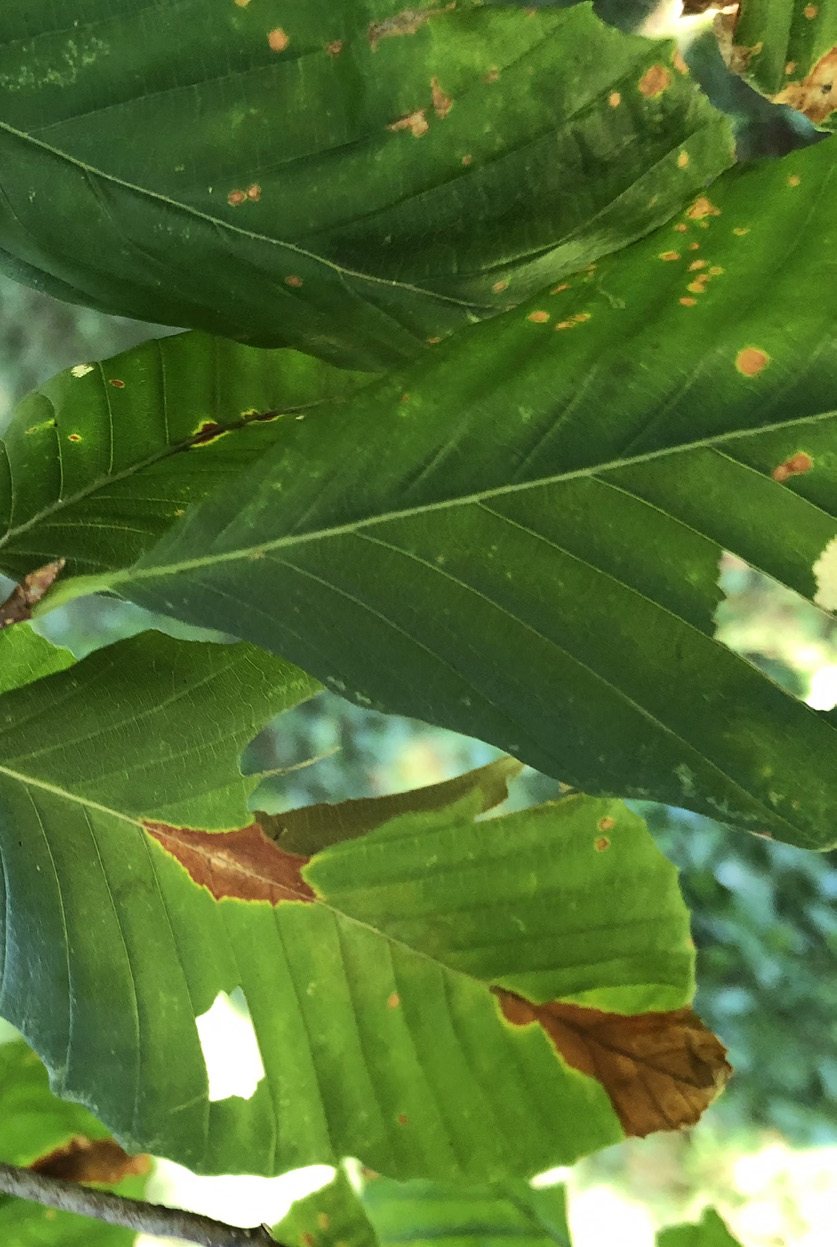

In [13]:
file_path = r"C:\Users\musta\OneDrive\Desktop\multimodaL\doc2.pdf"
output_dir = process_pdf(file_path)
query = "what are diseases on leaf"
response, images = query_system(query)
print("Enhanced Model Response:", response)

for image_path in images:
    print(image_path)
    display_single_image(image_path)
